In [1]:
import pandas as pd
import numpy as np
import unicodedata

import re
import string

import spacy

import gensim
from gensim import corpora
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df_fl = pd.read_excel("Florida_Senate_Sample_data.xlsx")
df_Ca = pd.read_excel("California_Senate_Sample_data.xlsx")

In [3]:
df_fl['State'] = 'FL'
df_Ca['State'] = 'CA'

In [4]:
df = pd.concat([df_fl, df_Ca])

## Cleaning 

In [31]:
#create a function to clean tweets
def cleanTxt(text):
    text = text.replace('\u2026','')
    text = re.sub(r'@[A-Za-z0-9_:]+', '', text) #remove @mentions
    text = re.sub(r'RT[\s]+', '', text) # remove ReTweets
    text = re.sub(r'https?:\/\/\S+', '', text) # remove hyperlinks 
    text = re.sub(r'(\n)', '', text)
    text = text.lower()
    
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    text = re.sub(r'[!]+', '', text)  # remove exclamation marks
    # remove emoticons
    text = re.sub(r'[:;=][\)\(\[\]DPOp]([pPoODsS/\\]+[vV])?|[\)\(\[\]DPOp][:=;][vV]?|[Xx][:;=][\)\(\[\]DPOp]|<3', '', text)
    # Remove special characters and symbols
    text = ''.join(c for c in text if unicodedata.category(c) != 'So' and unicodedata.category(c) != 'Sk')
    # Remove additional patterns
    text = re.sub(r'\[[^\]]*\]', '', text)  # remove square brackets and their contents
    text = re.sub(r'’|‘|“|”', '', text)  # remove specific quotation marks
    text = re.sub(r'—|–', '', text)  # remove dashes
    text = re.sub(r'\u2066|\u2069|\u200d', '', text)  # remove specific Unicode characters
    text = re.sub(r'¡|¢|‼️|•', '', text)  # remove specific symbols
    text = re.sub(r'𝟮𝟬𝟮𝟯|️⃣', '', text)  # remove specific Unicode characters
    # remove specific Chinese text
    text = re.sub(r'我和我的团队与加州理发和美容委员会合作，提供简体中文考试！我们的目标是为理发和美容行业的学生和被许可人提供更好的社区访问并减少语言障碍。我们很自豪地宣布这些考试现已生效，所以请分享这个消息', '', text)
    text = re.sub(r'我向蒙特利公园', '', text)  # remove specific Chinese text
    text = re.sub(r'枪击案的受害者和他们的家人表示哀悼。蒙特利公园兰利老年中心', '', text)  # remove specific Chinese text
    text = re.sub(r'提供受害者服务。请到那里寻求帮助', '', text)  # remove specific Chinese text
    text = re.sub(r'新年快乐', '', text)  # remove specific Chinese text
    text = re.sub(r'\u200dfunding', '', text)  # remove specific Unicode characters
    text = re.sub(r'️\u200d️\u200d️thank', '', text)  # remove specific Unicode characters
    text = re.sub(r'\u2066to', '', text)  # remove specific Unicode characters
    text = re.sub(r'\u2066', '', text)  # remove specific Unicode characters
    text = re.sub(r'ab–', '', text)  # remove specific text
    text = re.sub(r'¡ha', '', text)  # remove specific text
    text = re.sub(r'¡feliz', '', text)  # remove specific text
    text = re.sub(r'¡si', '', text)  # remove specific text
    text = re.sub(r'\u2066latest', '', text)  # remove specific Unicode characters
    text = re.sub(r'↓|→', '', text)  # remove arrows
    text = re.sub(r'backs—and|back—now', '', text)  # remove specific phrases
    text = re.sub(r'‼️', '', text)  # remove specific Unicode characters
    text = re.sub(r'•|•transitional|•national', '', text)  # remove specific phrases
    text = re.sub(r"['\[\],\u200b]", "", text)
    text = re.sub(r"['\[\],\u200b\uFE0F\u200D]", "", text)
    text = re.sub(r'[\[\]]', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = re.sub(r'\bu\b|\bca\b', '', text)
    text = re.sub(r'\bamp\b|\bsb\b|\bab\b|\bu\b|\bim\b|\bth\b|\brp\b|\bflorida\b|\bca\b|\bu\b|\bpm\b|\bfl\b', '', text)
    text = re.sub(r'\bu\b', '', text)
    text = text.replace('republican','')
    text = text.replace('florida','')
    #text = text.replace('community','') 
    text = re.sub(r'\bfl\b', '', text)# this eliminate only fl if it finds as one unique string on the text
    text = re.sub(r'\bpm\b', '', text)
    return text

In [32]:
df['text_clean'] = df['text'].apply(cleanTxt)

## Tokenization

In [33]:
from nltk.tokenize import word_tokenize

In [34]:
def tokenize_text(text):
    tokens = word_tokenize(text)
    return ' '.join(tokens)

In [35]:
df['tokenized_text'] = df['text_clean'].apply(tokenize_text)

## Stopwords

In [36]:
from nltk.corpus import stopwords

In [37]:
stop_words = stopwords.words('english')
stop_words.append('thank')
stop_words.append('thanks')
stop_words.append('floridian')
stop_words.append('californian')
stop_words.append('new')
stop_words.append('year')
stop_words.append('desantis')
stop_words.append('us')
stop_words.append('hb')
stop_words.append('california')
stop_words.append('today')
stop_words.append('broward')
stop_words.append('county')
stop_words.append('dont')
stop_words.append('much')
stop_words.append('many')

In [38]:
def remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words and len(token) > 1]
    return ' '.join(filtered_tokens)

In [39]:
df['stopwords_text'] = df['tokenized_text'].apply(remove_stopwords)

## Lemmatization

In [40]:
from nltk.stem import WordNetLemmatizer

In [41]:
lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    tokens = text.split()
    filtered_tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens]
    return ' '.join(filtered_tokens)

In [42]:
df['lemma_text'] = df['stopwords_text'].apply(preprocess_text)
df.head()

,user_name,text,created_at,favorite_count,party,State,text_clean,tokenized_text,stopwords_text,lemma_text
0,Marie Woodson,"RT @hcicollege: Thank you, Rep. Marie Woodson ...",2023-04-29,0,(D),FL,thank you rep marie woodson and the legislati...,thank you rep marie woodson and the legislativ...,rep marie woodson legislative black caucus sup...,rep marie woodson legislative black caucus sup...
1,Marie Woodson,Another one of our bills passed on the House F...,2023-04-27,3,(D),FL,another one of our bills passed on the house f...,another one of our bills passed on the house f...,another one bills passed house floor unanimous...,another one bill passed house floor unanimous ...
2,Marie Woodson,RT @Fla_Pol: House approves bill by @MarieWood...,2023-04-27,0,(D),FL,house approves bill by granting property tax ...,house approves bill by granting property tax e...,house approves bill granting property tax exem...,house approves bill granting property tax exem...
3,Marie Woodson,"This morning, I presented HB101 to ensure that...",2023-03-10,1,(D),FL,this morning i presented hb to ensure that all...,this morning i presented hb to ensure that all...,morning presented ensure first responders surv...,morning presented ensure first responder survi...
4,Marie Woodson,Very informative Broward Delegation meeting to...,2023-01-14,4,(D),FL,very informative broward delegation meeting to...,very informative broward delegation meeting to...,informative delegation meeting opportunity hea...,informative delegation meeting opportunity hea...


In [17]:
# Iterar sobre las filas del DataFrame
for index, row in df.iterrows():
    tokenized_text = row['tokenized_text']
    print(f"Row {index} - tokenized_text: {tokenized_text}")

Row 0 - tokenized_text: thank you rep marie woodson and the legislative black caucus for supporting hci college and accredited private n
Row 1 - tokenized_text: another one of our bills passed on the house floor with unanimous supporthd
Row 2 - tokenized_text: house approves bill by granting property tax exemptions for spouses of slain disabled federal agentsreporti
Row 3 - tokenized_text: this morning i presented hb to ensure that all first responders their surviving spouses are granted the same
Row 4 - tokenized_text: very informative broward delegation meeting today we had the opportunity to hear from many community leaders and a
Row 5 - tokenized_text: the executive director of fanm our wonderful mayor of miamidade county daniella levine cava all the other
Row 6 - tokenized_text: another commemoration of the earthquake that struck haiti and claimed so many lives this event was hoste
Row 7 - tokenized_text: our sincere thanks to mayor messam for this remembrance ceremony and the ack

In [209]:
# Iterar sobre las filas del DataFrame
for index, row in df.iterrows():
    stopwords_text = row['stopwords_text']
    print(f"Row {index} - stopwords_text: {stopwords_text}")

Row 0 - stopwords_text: rep marie woodson legislative black caucus supporting hci college accredited private
Row 1 - stopwords_text: another one bills passed house floor unanimous supporthd
Row 2 - stopwords_text: house approves bill granting property tax exemptions spouses slain disabled federal agentsreporti
Row 3 - stopwords_text: morning presented ensure first responders surviving spouses granted
Row 4 - stopwords_text: informative broward delegation meeting opportunity hear many community leaders
Row 5 - stopwords_text: executive director fanm wonderful mayor miamidade county daniella levine cava
Row 6 - stopwords_text: another commemoration earthquake struck haiti claimed many lives event hoste
Row 7 - stopwords_text: sincere mayor messam remembrance ceremony acknowledgment haitians contri
Row 8 - stopwords_text: call action come together restore security stability country rich
Row 9 - stopwords_text: commemorating anniversary devastating earthquake claimed many lives haiti cant


In [210]:
# Iterar sobre las filas del DataFrame
for index, row in df.iterrows():
    lemma_text = row['lemma_text']
    print(f"Row {index} - lemma_text: {lemma_text}")

Row 0 - lemma_text: rep marie woodson legislative black caucus supporting hci college accredited private
Row 1 - lemma_text: another one bill passed house floor unanimous supporthd
Row 2 - lemma_text: house approves bill granting property tax exemption spouse slain disabled federal agentsreporti
Row 3 - lemma_text: morning presented ensure first responder surviving spouse granted
Row 4 - lemma_text: informative broward delegation meeting opportunity hear many community leader
Row 5 - lemma_text: executive director fanm wonderful mayor miamidade county daniella levine cava
Row 6 - lemma_text: another commemoration earthquake struck haiti claimed many life event hoste
Row 7 - lemma_text: sincere mayor messam remembrance ceremony acknowledgment haitian contri
Row 8 - lemma_text: call action come together restore security stability country rich
Row 9 - lemma_text: commemorating anniversary devastating earthquake claimed many life haiti cant
Row 10 - lemma_text: honor present swearing cerem

## Keywords

In [43]:
kwords = ["pathway", "warmer",'warm',"sustainable development", "climate policy", "system change", "Adaptability",'cold','colder'
         "Adaptation", "Adaptation behaviour", "Adaptation limits", "Adaptation options", "Adaptation pathways",
         "Adaptive capacity", "Adaptive governance", "Aerosol", "Afforestation", "Air pollution", "asbesto",
         "Ambient persuasive technology", "Anomaly", "Anthropocene", "Anthropogenic", "Anthropogenic emissions",
         "Anthropogenic removals", "Atmosphere",'Battery','electric', "Battery electric vehicle (BEV)", "Biochar", "Biodiversity",
         "Bioenergy", "Biofuel", "Biomass", "Biophilic urbanism", "Black carbon (BC)", "Blue carbon", "Carbon",
         "Carbon budget", "Carbon cycle", "Carbon dioxide (CO2)", "CO2", "Carbon intensity", "Carbon neutrality",
         "Carbon price", "Carbon sink", "Clean Development Mechanism (CDM)", "Climate", "Climate change",
         "Climate change commitment", "Climate compatible development", "extreme weather", "climate event",
         "Climate governance", "Climate justice", "Climate model", "Climate neutrality", "Climate projection",
         "Climate resilient pathways", "Climate sensitivity", "Climate services", "Climate system", "Climate target",
         "Climate variability", "CO2 emission", "Conservation agriculture", "Constant composition commitment",
         "Constant emissions commitment", "Coupled Model Intercomparison Project (CMIP)", "Cumulative emissions",
         "Decarbonization", "Deforestation", "Demand- and supply-side measures", "Disaster",'emergency',
         "Disaster risk management", "Drought", "Early warning systems", "Earth system feedbacks", "Ecosystem",
         "Ecosystem services", "Effective climate sensitivity", "Electric vehicle", "Emission pathways",
         "Emission scenario", "Emission trajectories", "Emissions trading", "Energy efficiency", "Energy security",
         "Equilibrium climate sensitivity", "Exposure", "Extreme weather event", "Extreme climate event", "Flood",
         "Food wastage", "Forest", "Fossil fuels",'fuel' "Framework Convention on Climate Change",
         "Global mean surface temperature", "Global mean surface air temperature", "Global warming",
         "Green infrastructure", "Greenhouse gas", "Halocarbons", "Hazard", "Heatwave", "Heating",
         "Human behaviour", "Human behavioural change", "climate change Impact assessment", "Industrial revolution",
         "Infrastructure commitment", "Kyoto Protocol", "Land surface air temperature", "Local knowledge",
         "Megadrought", "CH4", "Methane",'mitigation', "Mitigation of climate change", "Mitigation behaviour", "Mitigation measures",
         "Mitigation option", "Mitigation pathways", "Mitigation scenario", "Negative emissions",
         "Net negative emissions", "Net zero CO2 emissions", "Net zero emissions", "N2O", "Nitrous oxide (N2O)",
         "Ocean acidification", "Ozone (O3)", "O3", "Paris Agreement", "Radiative forcing",
         "Reducing Emissions from Deforestation and Forest Degradation", "Reforestation", "Remaining carbon budget",
         "Risk assessment", "Risk management", "sea level", "Sea level change", "Sea surface temperature",
         "Social-ecological systems", "Soil carbon sequestration", "Soil moisture", "Solar radiation management",
         "Solar radiation modification", "Stratosphere", "Surface temperature", "Sustainability",
         "Sustainable development", "Sustainable Development Goals", "Technology transfer", "Temperature overshoot",
         "Tipping point", "Transformative change", "Transient climate response", "Transit-oriented development",
         "Transition", "United Nations Framework Convention on Climate Change", "Vulnerability", "Water cycle",
         "Zero emissions commitment",'deforestation','pollution','cars emissions','carbon intensity','damages','enviromental damage','petrol','gas',
         "climate", "change", "global", "warming", "carbon", "emissions", "greenhouse", "gases", "crisis","sustainability", "renewable", "energy", "mitigation", 
         "adaptation", "resilience", "footprint", "reducing", "neutrality", "action", "science", "policy", "capture", "deforestation", "reforestation","ocean", 
         "acidification", "extreme", "weather", "drought", "flood", "temperature", "pollution", "biodiversity", "conservation", "ecosystem", "loss", "renewables", 
          "solar", "wind","electricity","transportation", "carbon", "footprint", "agriculture", "sustainable", "development", "resilient", "cities", "urbanization",
         "renewable", "energy", "efficiency", "natural", "disasters", "reduction", "adaptation", "innovation", "renewable", "technology", "clean", "energy", 
         "investment",  "climate", "finance", "carbon", "pricing", "climate","justice", "renewable","jobs", "engagement", "awareness", "sustainable",
         "lifestyle", "policy", "makers", "advocacy", "public", "health","renewable", "infrastructure", "carbon", "offsets", "transition", "low-carbon", "decarbonization", 
         "sustainable", "consumption", "carbon", "collaboration",'Soil']
kwords = [word.lower() for word in kwords]

## Filtered data frame only if contains keywords

In [20]:
df_filter = df[df['lemma_text'].str.contains('|'.join(kwords))]

C:\Users\eyson\AppData\Local\Temp\ipykernel_16440\3660725807.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_filter = df[df['lemma_text'].str.contains('|'.join(kwords))]


In [21]:
df_filter.head()

,user_name,text,created_at,favorite_count,party,State,text_clean,tokenized_text,stopwords_text,lemma_text
8,Marie Woodson,2/3: Our call to action is to come together to...,2023-01-14,1,(D),FL,our call to action is to come together to res...,our call to action is to come together to rest...,call action come together restore security sta...,call action come together restore security sta...
11,Marie Woodson,RT @DolphinDems: Thank you @MartyKiar for your...,2023-01-14,0,(D),FL,thank you for your energy and dedication to e...,thank you for your energy and dedication to ed...,energy dedication educate property owners also...,energy dedication educate property owner also ...
12,Marie Woodson,RT @childrenstrust: Trust staff joined communi...,2023-01-14,0,(D),FL,trust staff joined community leaders to commem...,trust staff joined community leaders to commem...,trust staff joined community leaders commemora...,trust staff joined community leader commemorat...
13,Marie Woodson,Happy New Year to you and your family!!! \n\nB...,2023-01-01,7,(D),FL,happy new year to you and your family best wis...,happy new year to you and your family best wis...,happy family best wishes fun filled health pro...,happy family best wish fun filled health prosp...
15,Marie Woodson,Wishing you and your family a joyous and healt...,2022-12-25,4,(D),FL,wishing you and your family a joyous and healt...,wishing you and your family a joyous and healt...,wishing family joyous healthy christmashd,wishing family joyous healthy christmashd


In [22]:
df_filter.shape

(1228, 10)

## Validation

In [23]:
df_val = df_filter.copy()

df_val['validation_count'] = df_val['lemma_text'].str.count('|'.join(kwords))
regex = '(' + '|'.join(kwords) + ')'

df_val['keywords'] = df_val['lemma_text'].str.extractall(regex).groupby(level=0).apply(lambda x: ', '.join(x[0]))

df_val

,user_name,text,created_at,favorite_count,party,State,text_clean,tokenized_text,stopwords_text,lemma_text,validation_count,keywords
8,Marie Woodson,2/3: Our call to action is to come together to...,2023-01-14,1,(D),FL,our call to action is to come together to res...,our call to action is to come together to rest...,call action come together restore security sta...,call action come together restore security sta...,1,action
11,Marie Woodson,RT @DolphinDems: Thank you @MartyKiar for your...,2023-01-14,0,(D),FL,thank you for your energy and dedication to e...,thank you for your energy and dedication to ed...,energy dedication educate property owners also...,energy dedication educate property owner also ...,1,energy
12,Marie Woodson,RT @childrenstrust: Trust staff joined communi...,2023-01-14,0,(D),FL,trust staff joined community leaders to commem...,trust staff joined community leaders to commem...,trust staff joined community leaders commemora...,trust staff joined community leader commemorat...,2,"natural, disaster"
13,Marie Woodson,Happy New Year to you and your family!!! \n\nB...,2023-01-01,7,(D),FL,happy new year to you and your family best wis...,happy new year to you and your family best wis...,happy family best wishes fun filled health pro...,happy family best wish fun filled health prosp...,1,health
15,Marie Woodson,Wishing you and your family a joyous and healt...,2022-12-25,4,(D),FL,wishing you and your family a joyous and healt...,wishing you and your family a joyous and healt...,wishing family joyous healthy christmashd,wishing family joyous healthy christmashd,1,health
...,...,...,...,...,...,...,...,...,...,...,...,...
4239,Senator Rosilicie Ochoa Bogh,It was so good to see my local transportation ...,2023-02-02,7,(R),CA,it was so good to see my local transportation ...,it was so good to see my local transportation ...,good see local transportation agencies mobilit...,good see local transportation agency mobility ...,1,"pathway, transportation"
4240,Senator Rosilicie Ochoa Bogh,February is #NationalCancerPreventionMonth. On...,2023-02-02,4,(R),CA,february is nationalcancerpreventionmonth onet...,february is nationalcancerpreventionmonth onet...,february nationalcancerpreventionmonth onethir...,february nationalcancerpreventionmonth onethir...,1,action
4254,Senator Rosilicie Ochoa Bogh,Did you know the California Conservation Corps...,2023-01-31,9,(R),CA,did you know the california conservation corps...,did you know the california conservation corps...,know conservation corps inland empire district...,know conservation corp inland empire district ...,1,conservation
4256,Senator Rosilicie Ochoa Bogh,Has your natural gas bill gone up? Hearing fro...,2023-01-30,15,(R),CA,has your natural gas bill gone up hearing from...,has your natural gas bill gone up hearing from...,natural gas bill gone hearing helps better rep...,natural gas bill gone hearing help better repr...,2,"natural, gas"


In [24]:
df_val.iloc[992]['lemma_text']

'breaking amid recent storm gov say state ease drought restriction including request'

In [25]:
df_val.iloc[992]['keywords']

'drought'

## LDA

In [47]:
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import TfidfModel

In [59]:
import gensim.corpora as corpora

# Convertir las cadenas de texto en listas de tokens
tokenized_texts = [text.split() for text in df_filter['lemma_text']]

# Detectar n-grams
bigram_phrases = Phrases(tokenized_texts, min_count=5, threshold=10)
trigram_phrases = Phrases(bigram_phrases[tokenized_texts], min_count=5, threshold=10)

# Construir los modelos de n-grams
bigram_model = Phraser(bigram_phrases)
#trigram_model = Phraser(trigram_phrases)

# Aplicar los n-grams a los textos
tokenized_texts_bigram = bigram_model[tokenized_texts]
#tokenized_texts_trigram = trigram_model[tokenized_texts_bigram]

# Crear el diccionario
id2word = corpora.Dictionary(tokenized_texts_bigram)

# Crear el corpus
corpus = [id2word.doc2bow(tokens) for tokens in tokenized_texts_trigram]

# Calcular TF-IDF
tfidf_model = TfidfModel(corpus)
corpus_tfidf = tfidf_model[corpus]


In [63]:
from pprint import pprint
# number of topics
num_topics = 6
# Build LDA model
lda_model = gensim.models.LdaModel(corpus=corpus_tfidf,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       alpha='auto', eval_every=200,
                                       random_state=123)
                                     
        
# Print the Keyword 
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.003*"state" + 0.002*"public" + 0.002*"support" + 0.002*"community" + '
  '0.002*"bill" + 0.002*"service" + 0.002*"family" + 0.002*"healthcare" + '
  '0.002*"advocacy" + 0.002*"gas_tax"'),
 (1,
  '0.003*"policy" + 0.002*"health" + 0.002*"state" + 0.002*"public" + '
  '0.002*"take" + 0.002*"great" + 0.002*"discus" + 0.002*"support" + '
  '0.002*"criminal_justice" + 0.002*"see"'),
 (2,
  '0.003*"good" + 0.002*"energy" + 0.002*"help" + 0.002*"great" + 0.002*"work" '
  '+ 0.002*"happy" + 0.002*"tax" + 0.002*"policy" + 0.002*"bill" + '
  '0.002*"weather"'),
 (3,
  '0.002*"bill" + 0.002*"need" + 0.002*"congratulation" + 0.002*"member" + '
  '0.002*"crisis" + 0.002*"justice" + 0.002*"legislative" + 0.002*"fighting" + '
  '0.001*"change" + 0.001*"health"'),
 (4,
  '0.002*"public" + 0.002*"change" + 0.002*"bill" + 0.002*"healthcare" + '
  '0.002*"storm" + 0.002*"public_safety" + 0.002*"senate" + 0.002*"wind" + '
  '0.002*"state" + 0.002*"important"'),
 (5,
  '0.003*"committee" + 0.003*

In [65]:
# Obtener los datos del modelo LDA
topics = []
topic_perc_contrib = []
keywords = []
texts = []

for i, doc in enumerate(doc_lda):
    doc_topics = sorted(doc, key=lambda x: (x[1]), reverse=True)
    dominant_topic = doc_topics[0][0]
    topic_perc = doc_topics[0][1]
    keywords_list = lda_model.show_topic(dominant_topic)
    keywords_str = ", ".join([word for word, _ in keywords_list])
    text = " ".join(tokenized_texts_trigram[i])
    
    topics.append(dominant_topic)
    topic_perc_contrib.append(topic_perc)
    keywords.append(keywords_str)
    texts.append(text)

# Asignar los valores al nuevo DataFrame utilizando .loc
df_filter['Dominant_Topic'] = topics
df_filter['Topic_Perc_Contrib'] = topic_perc_contrib
df_filter['Keywords_LDA'] = keywords

C:\Users\eyson\AppData\Local\Temp\ipykernel_16440\3392990926.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['Dominant_Topic'] = topics
C:\Users\eyson\AppData\Local\Temp\ipykernel_16440\3392990926.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['Topic_Perc_Contrib'] = topic_perc_contrib
C:\Users\eyson\AppData\Local\Temp\ipykernel_16440\3392990926.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

## Data frame with LDA

In [66]:
df_filter.head(3)

,user_name,text,created_at,favorite_count,party,State,text_clean,tokenized_text,stopwords_text,lemma_text,Dominant_Topic,Topic_Perc_Contrib,Keywords_LDA
8,Marie Woodson,2/3: Our call to action is to come together to...,2023-01-14,1,(D),FL,our call to action is to come together to res...,our call to action is to come together to rest...,call action come together restore security sta...,call action come together restore security sta...,2,0.925244,"good, energy, help, great, work, happy, tax, p..."
11,Marie Woodson,RT @DolphinDems: Thank you @MartyKiar for your...,2023-01-14,0,(D),FL,thank you for your energy and dedication to e...,thank you for your energy and dedication to ed...,energy dedication educate property owners also...,energy dedication educate property owner also ...,2,0.906211,"good, energy, help, great, work, happy, tax, p..."
12,Marie Woodson,RT @childrenstrust: Trust staff joined communi...,2023-01-14,0,(D),FL,trust staff joined community leaders to commem...,trust staff joined community leaders to commem...,trust staff joined community leaders commemora...,trust staff joined community leader commemorat...,1,0.937831,"policy, health, state, public, take, great, di..."


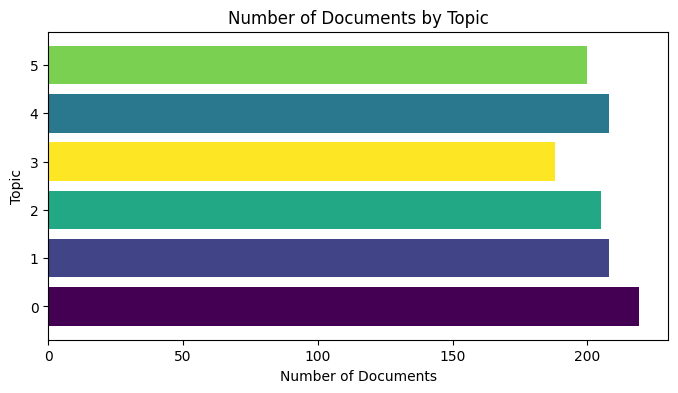

In [67]:
# Obtener el número de documentos por tema
doc_count_topic = df_filter['Dominant_Topic'].value_counts()

# Crear el histograma de barras horizontales con diferentes colores
plt.figure(figsize=(8, 4))
colors = plt.cm.viridis(np.linspace(0, 1, len(doc_count_topic)))
plt.barh(doc_count_topic.index, doc_count_topic.values, color=colors)
plt.title("Number of Documents by Topic")
plt.xlabel("Number of Documents")
plt.ylabel("Topic")
plt.grid(False)  # Desactivar cuadrícula
plt.show()

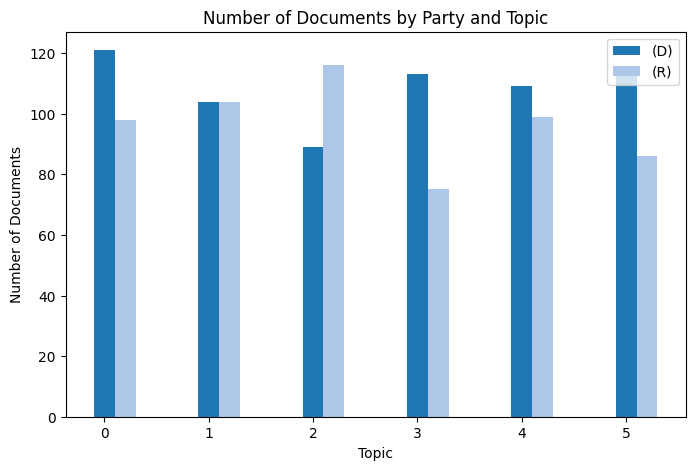

In [68]:
# Obtener el número de documentos por tema, agrupados por partido
doc_count_party_topic = df_filter.groupby(['party', 'Dominant_Topic']).size().unstack()

# Obtener los temas y partidos
topics = df_filter['Dominant_Topic'].unique()
parties = df_filter['party'].unique()

# Crear el histograma de barras agrupadas por partido
plt.figure(figsize=(8, 5))
bar_width = 0.2  # Ancho de las barras

# Recorrer cada partido y crear las barras para cada tema
for i, party in enumerate(parties):
    # Obtener los valores de recuento de documentos por tema para el partido actual
    party_values = doc_count_party_topic.loc[party].values

    # Calcular las posiciones de las barras para el partido actual
    party_positions = np.arange(len(party_values)) + i * bar_width

    # Crear las barras para el partido actual
    plt.bar(party_positions, party_values, width=bar_width, color=plt.cm.tab20(i), label=party)

plt.title("Number of Documents by Party and Topic")
plt.xlabel("Topic")
plt.ylabel("Number of Documents")
plt.grid(False) 
plt.legend()
plt.show()

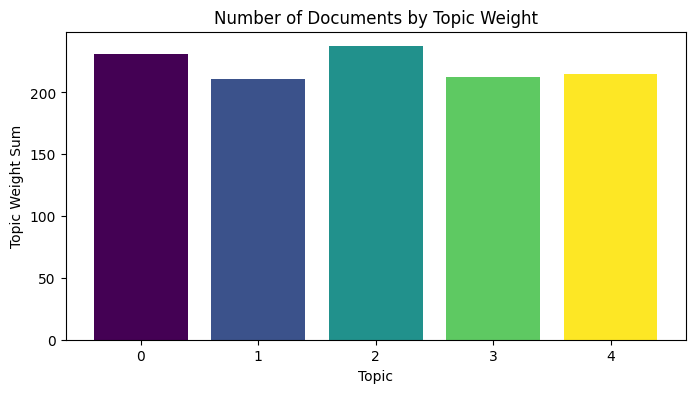

In [56]:
# Calcular la suma de la contribución de peso de cada tema
topic_weight_sum = df_filter.groupby('Dominant_Topic')['Topic_Perc_Contrib'].sum()

# Crear el histograma
plt.figure(figsize=(8, 4))
colors = plt.cm.viridis(np.linspace(0, 1, len(topic_weight_sum)))
plt.bar(topic_weight_sum.index, topic_weight_sum.values, color=colors)
plt.title("Number of Documents by Topic Weight")
plt.xlabel("Topic")
plt.ylabel("Topic Weight Sum")
plt.grid(False)  # Desactivar cuadrícula
plt.show()


## Vizualiation_LDA_Florida

In [69]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.030953  0.027818       1        1  17.935010
1     -0.037469 -0.001257       2        1  17.205249
4      0.012558  0.004639       3        1  17.025640
2      0.023547 -0.037202       4        1  16.596044
5      0.039564  0.035787       5        1  16.269703
3     -0.007246 -0.029785       6        1  14.968354, topic_info=                  Term      Freq      Total Category  logprob  loglift
126               good  9.000000   9.000000  Default  30.0000  30.0000
1725              zone  4.000000   4.000000  Default  29.0000  29.0000
915   criminal_justice  5.000000   5.000000  Default  28.0000  28.0000
1368          national  8.000000   8.000000  Default  27.0000  27.0000
50      congratulation  6.000000   6.000000  Default  26.0000  26.0000
...                ...       ...        ...      ...      ...      ...
1142            passed  2.102273   9.574670   Topic6  -6.7257   0.3831
0               action  2.233806  16.371149   Topic6  -6.6650  -0.0926
70                 day  2.218060  16.216896   Topic6  -6.6721  -0.0902
268          important  2.100154  10.389334   Topic6  -6.7267   0.3005
64              public  2.220089  21.753444   Topic6  -6.6712  -0.3830

[430 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
381       1  0.144515  abortion
381       2  0.144515  abortion
381       3  0.289030  abortion
381       4  0.144515  abortion
381       5  0.144515  abortion
...     ...       ...       ...
1597      5  0.673104       yet
1586      1  0.237441     young
1586      3  0.474882     young
1586      4  0.237441     young
1725      4  0.682511      zone

[967 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 5, 3, 6, 4])

#

# Good-of_fitness - Perplexity

C:\Users\eyson\anaconda3\envs\Python\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in scalar divide
  m_lr_i = np.log(numerator / denominator)
C:\Users\eyson\anaconda3\envs\Python\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in scalar divide
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


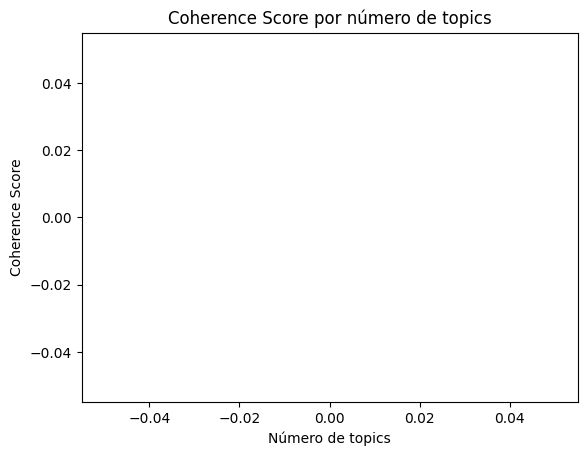

In [58]:
# Lista para almacenar los scores de coherencia
coherence_scores = []

# Rango de número de topics
min_topics = 2
max_topics = 8

# Iterar sobre diferentes números de topics
for num_topics in range(min_topics, max_topics+1):
    # Entrenar el modelo LDA con el número de topics actual
    lda_model = gensim.models.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=123)
    
    # Calcular el Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_texts, dictionary=id2word, coherence='c_v')
    try:
        coherence_score = coherence_model_lda.get_coherence()
    except Exception as e:
        coherence_score = np.nan
    
    # Almacenar el Coherence Score
    coherence_scores.append(coherence_score)

    # Graficar el número de topics vs el score de coherencia actual
    if np.isfinite(coherence_score):
        plt.scatter(num_topics, coherence_score, color='blue')
        plt.text(num_topics, coherence_score, round(coherence_score, 4), ha='center', va='bottom')

# Graficar el número de topics vs los scores de coherencia
plt.plot(range(min_topics, max_topics+1), coherence_scores, color='red')
plt.xlabel("Número de topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score por número de topics")
plt.show()